# Analyza nejistot minimalizace EMM

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pandas import DataFrame

Nejprve načtu histogramy odpovídající jednotlivým měřením

In [42]:
import numpy as np


# fotkor_z = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,1]
# voltages_z = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")[1,:]
# fotkor_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,5]
# voltages_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")[5,:]

# nacteni dat pouze v minimu EMM
fotkor_z = np.genfromtxt("03_05_20_EMM_min_z_final_delim.txt", delimiter="\t")[:,0]
voltages_z = np.genfromtxt("03_05_20_EMM_min_z_final_voltages.txt", delimiter="\t")[0,:]
fotkor_xz = np.genfromtxt("03_05_20_EMM_min_xz_multiple_delim.txt", delimiter="\t")[:,6]
voltages_xz = np.genfromtxt("03_05_20_EMM_min_xz_multiple_voltages.txt", delimiter="\t")[6,:]

# print(voltages_z)
# print(voltages_xz)

# pomocne promene
fotkor_z_shape = np.shape(fotkor_z)
fotkor_xz_shape = np.shape(fotkor_xz)
# dale predpokladam, ze signaly maji stejny pocet binu
# fotkor_shape = np.array( [fotkor_z_shape, fotkor_xz_shape] )

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = [100, 85] # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale_z = np.array( range(0,fotkor_z_shape[0]) ) *t_res
t_scale_xz = np.array( range(0,fotkor_xz_shape[0]) ) *t_res

t_scale = t_scale_z

background_photocounts = [190, 130] # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody

#---------- odecet pozadi v ose z
bg_ph_sum = background_photocounts[0] * t_measure[0]  # celkovy pocet fotonu pozadi za cas mereni

last_bin_ratio_z = fotkor_z[fotkor_z_shape[0]-2] / fotkor_z[fotkor_z_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_z = bg_ph_sum/(fotkor_z_shape[0]-2 + last_bin_ratio_z)

fotkor_z[:fotkor_z_shape[0]-2] = fotkor_z[:fotkor_z_shape[0]-2] - bg_ph_per_bin_z 
fotkor_z[fotkor_z_shape[0]-2] = fotkor_z[fotkor_z_shape[0]-2] - bg_ph_per_bin_z * last_bin_ratio_z
#--------------------
#--------- odecet pozadi v ose xz
bg_ph_sum = background_photocounts[1] * t_measure[1]  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio_xz = fotkor_xz[fotkor_xz_shape[0]-2] / fotkor_xz[fotkor_xz_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_xz = bg_ph_sum/(fotkor_xz_shape[0]-2 + last_bin_ratio_xz)

fotkor_xz[:fotkor_xz_shape[0]-2] = fotkor_xz[:fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz 
fotkor_xz[fotkor_xz_shape[0]-2] = fotkor_xz[fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz * last_bin_ratio_xz
# ------------------------------
#----------- odecet pozadi v ose xy

#----------------------------------

# vlozim signaly a voltage do matic
fotkor = np.transpose( np.array( [fotkor_z, fotkor_xz] ) ) # tvar: [data, osa]
voltages = np.transpose( np.array( [voltages_z, voltages_xz] ) ) # tvar: [data, osa]

fotkor_shape = np.shape(fotkor)

# celkovy pocet detekovanych fotonu
photon_sum = np.sum(fotkor, axis=0)
photon_sum

array([313002., 293578.])

In [43]:
# odhad periody triggeru
Omega = np.zeros(fotkor_shape[1])
Omega_sigma = np.zeros(fotkor_shape[1])

for i in range(fotkor_shape[1]):
    T_trig = ( fotkor[fotkor_shape[0]-2,i] / fotkor[fotkor_shape[0]-3,i] )* t_res + t_scale[fotkor_shape[0]-2]
    T_trig_sigma = t_res
    # frekvence buzeni pasti

    drive_freq = 1/T_trig
    drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
    Omega[i] = 2*np.pi * drive_freq
    Omega_sigma[i] = 2*np.pi * drive_freq_sigma
    print(drive_freq)
    
Omega = np.mean(Omega)
Omega_sigma = np.sqrt(0.5*np.sum(Omega_sigma**2) )

print(Omega/(2*np.pi))
print(Omega_sigma/(2*np.pi))

30036150.75204228
30037521.471918117
30036836.111980196
230966.15040694075


Fitovani histogramu

In [44]:
# residua vcetne vah
def likehood_transform(x, Omega, S, time_step, sigma):
    # definuju funkci vracejici logaritmus pravdepodobnosti, ze z distrubuce dane sinusovkou, co fituji vyberu pozorovane body
    # predpokladam, ze kazdy bod je normalne rozdelen kolem sinusovky
    
    len_S = len(S)
    #print(len_S)
    S_fit = x[0]*( 1 + x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) )
    
    sum_term = ( (S - S_fit )/sigma )**2
    log_term = np.log( np.ones(len_S) * sigma * np.sqrt(2*np.pi) )
    
    return( 0.5* np.sum( sum_term ) + np.sum(log_term) ) # vraci -log( likehood)

def likehood_transform_jac(x, Omega, S, time_step, sigma):
    # vektor jacob. likehood fce
    len_S = len(S)
    sum_term0 = 2/sigma**2 * (1 + x[1]*np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) ) *( x[0]*x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) + x[0] - S)
    
    sum_term1 = 2/sigma**2 * x[0]*np.cos( Omega * time_step * np.arange(0, len_S) + x[2] )*( x[0]*x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) + x[0] - S)
        
    sum_term2 = (-2/sigma**2) * x[0] * x[1] * ( x[0] * x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) + x[0] - S)*np.sin( Omega * time_step * np.arange(0, len_S) + x[2] )
        
    return( 0.5 * np.array( [np.sum(sum_term0), np.sum(sum_term1), np.sum(sum_term2)] ) )

def likehood_transform_sigma(x, Omega, S, time_step):
    # definuju funkci vracejici logaritmus pravdepodobnosti, ze z distrubuce dane sinusovkou, co fituji vyberu pozorovane body
    # predpokladam, ze kazdy bod je normalne rozdelen kolem sinusovky
    
    len_S = len(S)
    #print(len_S)
    S_fit = x[0]*( 1 + x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) )
    
    sum_term = ( (S - S_fit )/x[3] )**2
    log_term = np.log( np.ones(len_S) * x[3] * np.sqrt(2*np.pi) )
    
    return( 0.5* np.sum( sum_term ) + np.sum(log_term) ) # vraci -log( likehood)

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

In [51]:
from scipy.optimize import minimize
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []
fot_phi_sigma = []

hist_sigma = 0.09088658 * np.sqrt( photon_sum ) # sigma binu jednotlivych fotkor-signalu

for i in range(fotkor_shape[1]):
    
    # -----
    #podminky urcujici prijimuti reseni
    max_phi_unc = 0.9
    phi0 = 1.8
    
    #--- zde budu zkouset postupne ruzne pocatecni body tak, aby minimalizace vybrala globalni minimum
    x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
    -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), phi0]
#     x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
#         -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), phi0, 100]
#     fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10 )
    fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10,
                  jac=likehood_transform_jac)
#     fit = minimize(likehood_transform_sigma, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res), tol=1e-10)
    print(fit)
    print('\n')
    if ( np.sqrt(fit.hess_inv[2,2]) > max_phi_unc ) or (fit.x[1] < 0):
        x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
        -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), -phi0]
#         x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
#             -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), -phi0, 100]
        fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10 ,
                      jac=likehood_transform_jac)
#         fit = minimize(likehood_transform_sigma, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res), tol=1e-10)
        print(fit)
        print('\n')
        
    #---- odhad nejistot parametru----
#     C = fit.hess_inv  # variancni-kovariancni matice
    C = fit.hess_inv
    #------------------------------- 
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    #---- sigma delta s ku s
    Delta_S_S_ratio_sigma.append(np.sqrt( C[1,1]) )
    
    #---- sigma fot_phi
    fot_phi_sigma.append(np.sqrt(C[2,2]))
    
    
S_0 = x[0,:]  # parametry S_0
DeltaS = x[1,:] * S_0 # delta S

      fun: 679.7746688001598
 hess_inv: array([[1.98848997e+01, 1.11753054e-04, 1.60954054e-03],
       [1.11753054e-04, 6.94552798e-06, 3.55229398e-06],
       [1.60954054e-03, 3.55229398e-06, 3.31489381e-02]])
      jac: array([ 1.12633153e-10, -1.63283207e-07,  7.27061722e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 18
      nit: 13
     njev: 17
   status: 2
  success: False
        x: array([ 2.40674011e+03, -1.43219714e-02,  2.00888077e+00])


      fun: 679.7746688001598
 hess_inv: array([[ 1.98865806e+01, -1.10136192e-04,  3.61008455e-04],
       [-1.10136192e-04,  6.84947057e-06,  2.32327362e-07],
       [ 3.61008455e-04,  2.32327362e-07,  3.34882364e-02]])
      jac: array([-1.28970871e-09,  1.96506889e-07, -2.17763585e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 19
      nit: 14
     njev: 18
   status: 2
  success: False
        x: array([ 2.40674011e+03,  1.43219714e-02, -1.132711

In [53]:
print(DeltaS_S_ratio)
print(Delta_S_S_ratio_sigma)
print(fot_phi)
print(fot_phi_sigma)

[0.014321971390548301, 0.006819322883127832]
[0.0026171493220662695, 0.002666335484122352]
[-1.1327118832949652, -2.2185892009092125]
[0.1829979136257552, 0.3965458593784433]


In [54]:
hist_sigma

array([50.8479347 , 49.24492896])

priblizne odpovida random samplingu -> vizualni kontrola

In [55]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

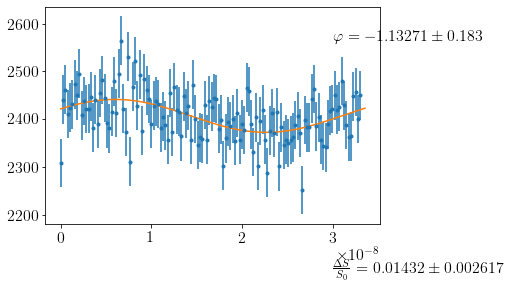

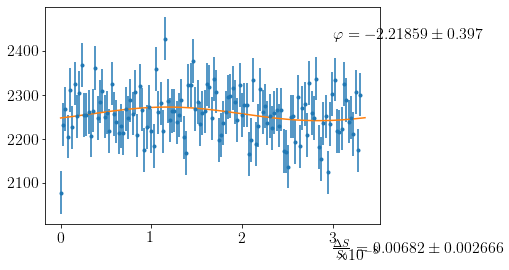

In [56]:
# plot fitu vcetne errorbaru
# my_dpi = 150
# siz = 100
# sizex = 16*siz
# sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func( [S_0[i],DeltaS[i],x[2,i]], Omega, time_fit)
    
    plt.figure()
    plt.errorbar(t_scale[:fotkor_shape[0]-2],fotkor[:fotkor_shape[0]-2,i],yerr=hist_sigma[i],fmt='.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(DeltaS_S_ratio[i], Delta_S_S_ratio_sigma[i])
    plt.text(3e-8, fotkor[:,i].max()-500,text) 
    text2 = r'$\varphi  = {:.5f} \pm {:.3}$'.format(fot_phi[i], sigmas[2,i])
    plt.text(3e-8, fotkor[:,i].max(),text2) 


ok

## Urceni $\beta$ + nejistoty

In [57]:
# parametry vypoctu beta

decay_rate = 2*np.pi * 21.008e6  # decay rate dle tabulek NISTu
laser_detun = -32e6 * 2*np.pi  # detuning 
laser_detun_sigma = 4e6 * 2*np.pi # sigma detun

Vyuzijeme nelinearniho sireni chyb. Tedy
\begin{equation}
    \mathcal{\Sigma}^\beta = \mathcal{J}^\beta \mathcal{\Sigma} \mathcal{J }^{\beta \rm T}
\end{equation}

Jakobian $\mathcal{J}^\beta$ vyjadrime pomoci jakobianu $\mathcal{J}^g$, kde $F(\beta, \frac{\Delta S}{S_0}, \Omega, \Delta)=0$, coz je rovnice, kterou resime numericky.

In [58]:
# numericke reseni deltaS/S -> beta

from scipy.optimize import fsolve
from scipy.special import j0, j1

def get_A(decay_rate, detun):
    # returns driven oscillator amplitude in point given by detun param.
    return 1 / 2 * (decay_rate / 2 - detun * 1j) / (detun ** 2 + (decay_rate / 2) ** 2)

def fl_signal(beta, laser_detun, Omega, decay_rate):
    # function calculates deltaS/S0 photon-correlation signal
    # input: beta, laser detuning, RF drive freq, decay rate
    A_minus = get_A(decay_rate, laser_detun - Omega)
    A_plus = get_A(decay_rate, laser_detun + Omega)
    A = get_A(decay_rate, laser_detun)

    numer = 2 * j0(beta) * j1(beta) * np.abs(np.conj(A) * A_plus - A * np.conj(A_minus))
    denom = j0(beta) ** 2 * np.abs(A) ** 2 + j1(beta) ** 2 * (np.abs(A_plus) ** 2 + np.abs(A_minus) ** 2)

    return numer / denom

def get_beta(Omega, decay_rate, laser_detun, norm_mod_amp):
    # function calculates the corresponding beta for given known parameters
    # input: drive frequency, decay_rate, laser detuning, normalized modulation amplitude given by ph_corr_signal
    # output: float value of beta
    def root_func(beta, laser_detun, Omega, decay_rate, norm_mod_amp):
        return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

    sol = fsolve(root_func, np.array([0.01]), args=(laser_detun, Omega, decay_rate, norm_mod_amp), full_output=1)
    return float(sol[0])

In [59]:
from scipy.optimize import approx_fprime, check_grad

def root_func(x):
    [beta, norm_mod_amp, Omega, laser_detun, decay_rate] = x
    return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

def root_func_grad(x):
#     [beta, norm_mod_amp, Omega, laser_detun, decay_rate] = x
    epsilon = 5e-6
    return( approx_fprime(x, root_func, x*epsilon ) )

In [60]:
from scipy.optimize import approx_fprime, check_grad

# get beta
beta = np.zeros(fotkor_shape[1])
beta_sigma = np.zeros(fotkor_shape[1])
for k in range(fotkor_shape[1]):
    beta[k] = get_beta(Omega, decay_rate, laser_detun, DeltaS_S_ratio[k])
    
    # get sigma beta
    jacob_F = root_func_grad( np.array([beta[k], DeltaS_S_ratio[k], Omega, laser_detun, decay_rate]) ) 
    # [dF/dbeta, dF/ddeltaS/S, dF/dOmega, dF/dDelta, dF/dGamma]
    
    # variance-cov parametru
    Sigma_param = np.diag([Delta_S_S_ratio_sigma[k]**2, Omega_sigma**2, laser_detun_sigma**2])
    
    beta_sigma[k] = np.sqrt( jacob_F[0]**-2 * jacob_F[1:-1] @ Sigma_param @ np.transpose( jacob_F[1:-1] ) )
    
    

In [61]:
print(beta)
print(beta_sigma)

[0.00500948 0.00238512]
[0.00091698 0.00093293]


In [28]:
jacob_F[2]**2  * Omega_sigma**2

3.006603578501729e-09

In [29]:
check_grad(root_func, root_func_grad,
           np.array([beta[0], DeltaS_S_ratio[0], Omega, laser_detun, decay_rate]))

1.0635770267881193e-09

In [30]:
jacob_F[1:-1] @ Sigma_param @ np.transpose( jacob_F[1:-1] )

7.429037665530807e-06

In [31]:
root_func_grad(np.array([beta[0], DeltaS_S_ratio[0], Omega, laser_detun, decay_rate]))

array([ 2.85862366e+00, -1.00000000e+00,  7.93507987e-11,  3.68060868e-12,
       -1.07851723e-10])

## projekce indexu $\beta$ do os $x,y$

In [101]:
# definice funkci, ktere prepocitavaji prumety beta_z,beta_xz,beta_xy do os x,y,z

# korekce funkce vracejici prumety beta pro svazek xy mirici lib. smerem
def get_beta_xyz_phi_xyz_Sxy_z_proj(variables):
    # input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma, a, c]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # jednotkovy vektor svazku Sxy = [a,b,c]

    # output: beta_xyz = [beta_x, beta_y, beta_z]
    
    #### overeno
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1 / np.sin(gamma) * (
                beta[1] * np.exp(1j * fot_phi[1]) - beta[0] * np.cos(gamma) * np.exp(1j * fot_phi[0]))
    beta_y_comp = 1 / b * ( beta[2] * np.exp(1j * fot_phi[2]) - a*beta_x_comp - c*beta[0]*np.exp(1j * fot_phi[0]) )

    return (np.array([np.abs(beta_x_comp), np.abs(beta_y_comp)]),
            np.array([np.angle(beta_x_comp), np.angle(beta_y_comp)])
            )

def get_beta_x(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
    return( np.abs(beta_x_comp) )

def get_phi_x(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
    return( np.angle(beta_x_comp) )

def get_beta_y(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1 / np.sin(gamma) * (
                beta[1] * np.exp(1j * fot_phi[1]) - beta[0] * np.cos(gamma) * np.exp(1j * fot_phi[0]))
    beta_y_comp = 1 / b * ( beta[2] * np.exp(1j * fot_phi[2]) - a*beta_x_comp - c*beta[0]*np.exp(1j * fot_phi[0]) )

    return( np.abs(beta_y_comp) )

def get_phi_y(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1 / np.sin(gamma) * (
                beta[1] * np.exp(1j * fot_phi[1]) - beta[0] * np.cos(gamma) * np.exp(1j * fot_phi[0]))
    beta_y_comp = 1 / b * ( beta[2] * np.exp(1j * fot_phi[2]) - a*beta_x_comp - c*beta[0]*np.exp(1j * fot_phi[0]) )

    
    return( np.angle(beta_y_comp) )

def get_beta_xyz_phi_xyz(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    
    # output: beta_xyz = [beta_x, beta_y, beta_z]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    epsilon = variables[7]
    
    beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
    beta_y_comp = 1/np.cos(epsilon) * ( np.sin(epsilon) * beta_x_comp  - beta[2]*np.exp(1j*fot_phi[2]) )
    
    return(np.array( [np.abs(beta_x_comp), np.abs(beta_y_comp)]), 
           np.array( [np.angle(beta_x_comp), np.angle(beta_y_comp) ] ) 
          ) 


# def get_beta_x(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     return( np.abs(beta_x_comp) )

# def get_phi_x(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     return( np.angle(beta_x_comp) )

# def get_beta_y(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     beta_y_comp = 1/np.cos(epsilon) * ( np.sin(epsilon) * beta_x_comp  - beta[2]*np.exp(1j*fot_phi[2]) )
    
#     return( np.abs(beta_y_comp) )

# def get_phi_y(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     beta_y_comp = 1/np.cos(epsilon) * ( np.sin(epsilon) * beta_x_comp  - beta[2]*np.exp(1j*fot_phi[2]) )
    
#     return( np.angle(beta_y_comp) )

def get_beta_x_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_x, epsi_err) )

def get_beta_y_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_y, epsi_err) )

def get_phi_x_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_x, epsi_err) )

def get_phi_y_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_y, epsi_err) )

def get_beta_x_y_phi_x_y_jacob(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: jacobian 
    
    return( np.array([ get_beta_x_jac(variables), get_beta_y_jac(variables), 
                      get_phi_x_jac(variables), get_phi_y_jac(variables) ])
          )
  

In [71]:
get_beta_xyz_phi_xyz([beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 21/180 * np.pi])

(array([0.00455188, 0.00486243]), array([2.72385491, 2.99528632]))

In [98]:
# get_beta_xyz_phi_xyz_Sxy_z_proj([beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 0.3572, -0.0722])
get_beta_xyz_phi_xyz_Sxy_z_proj([beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 0.3583679, 0])

(array([0.00455188, 0.00486243]), array([2.72385491, 2.99528634]))

In [100]:
check_grad(get_phi_y, get_phi_y_jac, [beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 21/180 * np.pi])

4.515336113824745e-05

In [102]:
check_grad(get_phi_y, get_phi_y_jac, [beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 0.3583679, 0])

4.5124895720102064e-05

In [21]:
get_beta_x_y_phi_x_y_jacob( [beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 0.2] )

array([[ 9.76583956e-01,  1.39704899e+00,  0.00000000e+00,
        -7.95845854e-04,  7.95845854e-04,  0.00000000e+00,
        -1.22866956e-02,  0.00000000e+00],
       [ 1.27823509e-01,  8.73160605e-02,  8.75656332e-01,
         5.82001461e-04,  9.89259976e-04, -1.57126139e-03,
        -1.26204407e-03,  4.58569836e-03],
       [ 2.48022818e+01, -2.53247014e+01,  0.00000000e+00,
         4.16486956e-01,  5.83513038e-01,  0.00000000e+00,
        -9.17500964e-02,  0.00000000e+00],
       [-4.60544187e+01, -7.99301551e+01,  1.53316131e+02,
         1.38416123e-01,  9.26012600e-02,  7.68982611e-01,
         6.30316732e-01, -2.26900245e+00]])

Prepocitam bety a phi na do os $x,y,z$

In [74]:
## uhly detekcnich svazku
gamma = 45.07/180 * np.pi
gamma_sigma = 6/180 * np.pi
# epsilon = 20/180 * np.pi
# epsilon_sigma = 1/180 * np.pi

a = 0.3572
a_sigma = 0.01
c = -0.0722
c_sigma = 0.008


In [75]:
[beta_x_y, phi_x_y] = get_beta_xyz_phi_xyz_Sxy_z_proj( [beta[0],beta[1],0.002, fot_phi[0],fot_phi[1],1.4,gamma, a, c] )
beta_xyz = np.append(beta_x_y, beta[0]) # [beta_x, beta_y, beta_z]
phi_xyz = np.append(phi_x_y, fot_phi[0]) # [phi_x, phi_y, phi_z]

#--- nejistoty zakonem sireni chyb
# sirim kovariancni matici diag( sigma^2 beta, sigma^2 phi, simga^2 gamma, epsilon_sigma^2)

# sigma_params = np.diag([beta_sigma[0]**2, beta_sigma[1]**2, 8e-4**2, fot_phi_sigma[0]**2, fot_phi_sigma[1]**2, 
#                         0.1**2, gamma_sigma**2, epsilon_sigma**2 ])

sigma_params = np.diag([beta_sigma[0]**2, beta_sigma[1]**2, 8e-4**2, fot_phi_sigma[0]**2, fot_phi_sigma[1]**2, 
                        0.1**2, gamma_sigma**2, a_sigma**2, c_sigma**2 ])

jacob_beta_phi_xy = get_beta_x_y_phi_x_y_jacob([beta[0],beta[1],0.002, fot_phi[0],fot_phi[1],1.4,gamma, a, c])

sigma_beta_phi_xy = jacob_beta_phi_xy @ sigma_params @ np.transpose(jacob_beta_phi_xy)

beta_xyz_sigma = np.sqrt( np.diag(sigma_beta_phi_xy)[:2] )
phi_xyz_sigma = np.sqrt( np.diag(sigma_beta_phi_xy)[2:] )

beta_xyz_sigma = np.append(beta_xyz_sigma, beta_sigma[0])
phi_xyz_sigma = np.append(phi_xyz_sigma, fot_phi_sigma[0])

print(beta_xyz)
print(beta_xyz_sigma)
print(phi_xyz)
print(phi_xyz_sigma)

[0.00454171 0.00237238 0.00500948]
[0.00183743 0.00085881 0.00091698]
[ 2.72473783 -2.67869254 -1.13271188]
[0.36139281 0.43285007 0.18299791]


In [76]:
np.sqrt( np.diagonal(sigma_beta_phi_xy) )

In [78]:
jacob_beta_phi_xy

array([[ 7.52690117e-01,  3.23307758e-01,  0.00000000e+00,
         3.27952127e-03, -3.27952136e-03,  0.00000000e+00,
        -8.31043533e-03,  0.00000000e+00,  0.00000000e+00],
       [-1.14178807e-02,  4.85455435e-01,  6.35854700e-01,
         2.30451803e-03, -5.73814694e-04, -1.73070338e-03,
        -1.05991934e-03,  4.08555360e-03, -6.40368401e-05],
       [-1.44144330e+02,  3.02747107e+02,  0.00000000e+00,
         8.30212832e-01,  1.69787118e-01,  0.00000000e+00,
         7.23856219e-01,  0.00000000e+00,  0.00000000e+00],
       [-1.93911502e+02,  1.01408933e+02,  3.64760471e+02,
        -2.41107578e-02,  4.88063545e-01,  5.36047295e-01,
         1.37418548e+00, -1.58415041e+00,  2.26681944e+00]])

In [77]:
get_beta_x_jac([beta[0],beta[1],0.05, fot_phi[0],fot_phi[1],0.5, gamma, epsilon_sigma]) @ np.diag([beta_sigma[0]**2, beta_sigma[1]**2, 8e-4**2, fot_phi_sigma[0]**2, fot_phi_sigma[1]**2, 
                        0.1**2, gamma_sigma**2, epsilon_sigma**2 ])

NameError: name 'epsilon_sigma' is not defined

In [26]:
get_beta_x_jac([beta[0],beta[1],0.05, fot_phi[0],fot_phi[1],0.5, gamma, epsilon_sigma]) @ np.diag([beta_sigma[0]**2, beta_sigma[1]**2, 8e-4**2, fot_phi_sigma[0]**2, fot_phi_sigma[1]**2, 
                        0.1**2, gamma_sigma**2, epsilon_sigma**2 ]) @ np.transpose( get_beta_x_jac([beta[0],beta[1],0.05, fot_phi[0],fot_phi[1],0.5, gamma, epsilon_sigma]) )

3.321758631549659e-06

## transformace do soustavy $(xyz)^{\prime}$

In [79]:
def get_beta_xyz_prime(variables):
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz ) )

def get_phi_xyz_prime(variables):
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz ) )

def get_beta_x_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[0] )  

def get_phi_x_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[0] )

def get_beta_y_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[1] )  

def get_phi_y_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[1] )

def get_beta_z_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[2] )  

def get_phi_z_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[2] )

def get_beta_x_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_x_prime, epsi_err) )

def get_phi_x_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_x_prime, epsi_err) ) 
           
def get_beta_y_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_y_prime, epsi_err) )

def get_phi_y_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_y_prime, epsi_err) )
           
def get_beta_z_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_z_prime, epsi_err) )

def get_phi_z_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_z_prime, epsi_err) )

def get_beta_x_y_phi_x_y_prime_jacob(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: jacobian 
    
    return( np.array([ get_beta_x_prime_jac(variables), get_beta_y_prime_jac(variables), get_beta_z_prime_jac(variables),
                      get_phi_x_prime_jac(variables), get_phi_y_prime_jac(variables),
                     get_phi_z_prime_jac(variables)])
          )

funkce transformuji beta do jine soustavy dle matice transformace

jednotlive slozky maji amplitydy a faze:

In [80]:
beta_xyz_prime = get_beta_xyz_prime(np.array( [beta_xyz[0],beta_xyz[1],beta_xyz[2], phi_xyz[0], phi_xyz[1], phi_xyz[2] ] ))
beta_xyz_prime

array([0.00250211, 0.00447155, 0.00500948])

In [81]:
phi_xyz_prime = get_phi_xyz_prime(np.array( [beta_xyz[0],beta_xyz[1],beta_xyz[2], phi_xyz[0], phi_xyz[1], phi_xyz[2] ] ))
phi_xyz_prime

array([ 2.18182385,  3.01801171, -1.13271188])

sireni nejistot: jacobian bude vypadat takto: $R \cdot \partial b_i /\partial \rm params $

In [83]:
# jacobian
# jacob_xyz_xyz_prime = trans_xyz_xyz_prime @ np.array( [ [np.exp(1j*phi_xyz[0]), 0, 0, 1j*beta_xyz[0]* np.exp(1j*phi_xyz[0]), 0, 0],
#             [0, np.exp(1j*phi_xyz[1]), 0, 0, 1j*beta_xyz[1]* np.exp(1j*phi_xyz[1]), 0],
#             [0, 0, np.exp(1j*phi_xyz[2]), 0, 0, 1j*beta_xyz[2]* np.exp(1j*phi_xyz[2])]
#           ] )
# jacob_xyz_xyz_prime

jacob_xyz_xyz_prime = get_beta_x_y_phi_x_y_prime_jacob(np.array( [beta_xyz[0],beta_xyz[1],beta_xyz[2], phi_xyz[0], phi_xyz[1], phi_xyz[2] ] ))
print( DataFrame(jacob_xyz_xyz_prime) )

            0           1    2         3         4    5
0    0.605430   -0.104358  0.0 -0.001659  0.001659  0.0
1    0.676915    0.588945  0.0  0.000928 -0.000928  0.0
2    0.000000    0.000000  1.0  0.000000  0.000000  0.0
3  146.002572 -279.510004  0.0  1.098948 -0.098948  0.0
4  -45.714723   87.516874  0.0  0.687536  0.312464  0.0
5    0.000000    0.000000  0.0  0.000000  0.000000  1.0


In [84]:
sigma_beta_phi_xy_trans = np.zeros((6,6))

sigma_beta_phi_xy_trans[:2,:2] = sigma_beta_phi_xy[:2,:2]
sigma_beta_phi_xy_trans[2,2] = beta_xyz_sigma[2]**2
sigma_beta_phi_xy_trans[0, 3:5] = sigma_beta_phi_xy[0,2:4]
sigma_beta_phi_xy_trans[1, 3:5] = sigma_beta_phi_xy[1,2:4]
sigma_beta_phi_xy_trans[3, 3:5] = sigma_beta_phi_xy[2,2:4]
sigma_beta_phi_xy_trans[4, 3:5] = sigma_beta_phi_xy[3,2:4]
sigma_beta_phi_xy_trans[5,5] = phi_xyz_sigma[2]**2

for i in range(6):
    for k in range(i):
        sigma_beta_phi_xy_trans[i,k] = sigma_beta_phi_xy_trans[k,i]
        
print( DataFrame(sigma_beta_phi_xy_trans) )
print( DataFrame(sigma_beta_phi_xy) )

              0             1             2         3         4         5
0  3.376148e-06  7.749823e-07  0.000000e+00 -0.000068 -0.000474  0.000000
1  7.749823e-07  7.375501e-07  0.000000e+00  0.000170  0.000121  0.000000
2  0.000000e+00  0.000000e+00  8.408609e-07  0.000000  0.000000  0.000000
3 -6.838845e-05  1.696369e-04  0.000000e+00  0.130605  0.073493  0.000000
4 -4.737701e-04  1.213409e-04  0.000000e+00  0.073493  0.187359  0.000000
5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.000000  0.033488
              0             1         2         3
0  3.376148e-06  7.749823e-07 -0.000068 -0.000474
1  7.749823e-07  7.375501e-07  0.000170  0.000121
2 -6.838845e-05  1.696369e-04  0.130605  0.073493
3 -4.737701e-04  1.213409e-04  0.073493  0.187359


In [85]:
# sireni chyb:
sigma_beta_phi_xyz_prime = jacob_xyz_xyz_prime @ sigma_beta_phi_xy_trans @ np.transpose( jacob_xyz_xyz_prime ) 

In [86]:
beta_xyz_prime_sigma = np.sqrt( np.diag(sigma_beta_phi_xyz_prime)[:3] ) 
phi_xyz_prime_sigma = np.sqrt(  np.diag(sigma_beta_phi_xyz_prime)[3:6] ) 

In [87]:
print(beta_xyz_prime)
print(beta_xyz_prime_sigma)
print(phi_xyz_prime)
print(phi_xyz_prime_sigma)

[0.00250211 0.00447155 0.00500948]
[0.00090587 0.00176931 0.00091698]
[ 2.18182385  3.01801171 -1.13271188]
[0.32273791 0.40372666 0.18299791]


In [88]:
np.sqrt( np.diag(sigma_beta_phi_xyz_prime)[3:-1])

array([0.32273791, 0.40372666])

In [89]:
sigma_beta_phi_xyz_prime

array([[ 8.20595150e-07,  1.01721409e-06,  0.00000000e+00,
        -5.69587859e-05, -1.72022306e-04,  0.00000000e+00],
       [ 1.01721409e-06,  3.13044614e-06,  0.00000000e+00,
         3.26991525e-04, -9.22881336e-05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  8.40860949e-07,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.69587859e-05,  3.26991525e-04,  0.00000000e+00,
         1.04159757e-01,  3.72344610e-02,  0.00000000e+00],
       [-1.72022306e-04, -9.22881336e-05,  0.00000000e+00,
         3.72344610e-02,  1.62995214e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.34882360e-02]])

## sedi, ok, ale neuvazuju korelaci mezi beta_z a phi_z, takze neni to idealka

## vypocet elektrickeho pole

In [90]:
# dalsi parametry
m = 40 * 1.66053904e-27 # calcium mass
k_vec = 2*np.pi * 1/(397e-9) # wave vector
e = 1.60217662e-19 # elem charge

In [91]:
# get E-fields
E_rf = (m*Omega**2 / (k_vec*e)) * beta_xyz
E_rf_sigma = np.sqrt( (beta_xyz_sigma*m*Omega**2 / (k_vec*e))**2 + (2*m*Omega / (k_vec*e) * beta_xyz * Omega_sigma)**2  ) # propagase chyb

print(E_rf)
print(E_rf_sigma)
m*Omega**2/(e*k_vec) * beta_xyz_sigma

[4.23737377 2.21340637 4.67380172]
[1.7155435  0.80198222 0.85855252]


array([1.71430536, 0.8012595 , 0.85553844])

jak velkou roli hraje nejistota omega?

In [92]:
beta_xyz**2 / Omega**2 * Omega_sigma**2 / beta_xyz_sigma**2

array([0.00036125, 0.00045119, 0.00176461])

vidim, ze desetina procenta prislusi nejistote omega

# Odhad freq. posuvu

## Doppler shift

In [93]:
c = 299792458 # rychlost svetla

doppler_2nd_EMM = - (Omega /(2*c*k_vec))**2 * sum(beta_xyz**2)
print(doppler_2nd_EMM)

-2.0310948636531946e-20


nejistota

In [94]:
jacob_doppler_EMM = - Omega/(2*c**2 * k_vec**2) * np.array( [sum(beta_xyz**2), Omega * beta_xyz[0], 
                                                             Omega* beta_xyz[1], Omega* beta_xyz[2]] )
sigma_doppler_EMM_propagation = np.zeros((4,4))
sigma_doppler_EMM_propagation[0,0] = Omega_sigma**2
sigma_doppler_EMM_propagation[1,1:3] = sigma_beta_phi_xy[0,:2]
sigma_doppler_EMM_propagation[2,1:3] = sigma_beta_phi_xy[1,:2]
sigma_doppler_EMM_propagation[3,3] = beta_xyz_sigma[2]**2

DataFrame(jacob_doppler_EMM)
print( DataFrame(sigma_doppler_EMM_propagation) )
DataFrame(sigma_beta_phi_xy)

              0             1             2             3
0  2.105991e+12  0.000000e+00  0.000000e+00  0.000000e+00
1  0.000000e+00  3.376148e-06  7.749823e-07  0.000000e+00
2  0.000000e+00  7.749823e-07  7.375501e-07  0.000000e+00
3  0.000000e+00  0.000000e+00  0.000000e+00  8.408609e-07


,0,1,2,3
0,3.376148e-06,7.749823e-07,-0.000068,-0.000474
1,7.749823e-07,7.375501e-07,0.000170,0.000121
2,-6.838845e-05,1.696369e-04,0.130605,0.073493
3,-4.737701e-04,1.213409e-04,0.073493,0.187359


In [95]:
doppler_2nd_EMM_sigma = np.sqrt( jacob_doppler_EMM @ sigma_doppler_EMM_propagation @ np.transpose(jacob_doppler_EMM) )
doppler_2nd_EMM_sigma

8.362565022387836e-21